In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
warnings.filterwarnings('ignore')

In [2]:
os.chdir("D:\DATA SCIENCE\COURSE\Projects\Project_Cab_Fare_Prediction")
os.getcwd()

'D:\\DATA SCIENCE\\COURSE\\Projects\\Project_Cab_Fare_Prediction'

In [3]:
train=pd.read_csv("cleaned_train.csv")
test=pd.read_csv("cleaned_test.csv")
test.shape,train.shape

((9914, 20), (15698, 21))

In [4]:
train.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_date', 'pickup_day',
       'pickup_hour', 'pickup_day_of_week', 'pickup_month', 'pickup_year',
       'distance_km', 'is_pickup_near_jfk', 'is_dropoff_near_jfk',
       'is_pickup_near_lgr', 'is_dropoff_near_lgr', 'is_pickup_near_newark',
       'is_dropoff_near_newark', 'pickup_borough', 'dropoff_borough'],
      dtype='object')

In [5]:
#clean data for baseline model using only date and time features no extra features
def processDataForModelling(data,target,drop_cols,is_train=True,split=0.25):
    data_1=data.drop(drop_cols,axis=1)
    # One hot Encoding
    #data_1=pd.get_dummies(data_1)
    if is_train==True:
        X=data_1.drop([target],axis=1)
        Y=data_1[target]
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=split,random_state=123)
        
        print("Shape of Training Features",X_train.shape)
        print("Shape of Validation Features ",X_test.shape)
        
        return X_train, X_test, Y_train, Y_test
    else:
        print ("Shape of Test Data",data_1.shape)
        return data_1
        

In [6]:
X_train, X_test, Y_train, Y_test=processDataForModelling(train,'fare_amount',drop_cols=['distance_km', 'is_pickup_near_jfk',
       'is_dropoff_near_jfk', 'is_pickup_near_lgr', 'is_dropoff_near_lgr',
       'is_pickup_near_newark', 'is_dropoff_near_newark', 'pickup_borough',
       'dropoff_borough','pickup_datetime','pickup_date'],is_train=True,split=0.2)


Shape of Training Features (12558, 9)
Shape of Validation Features  (3140, 9)


In [7]:
Y_train.shape, Y_test.shape

((12558,), (3140,))

In [8]:
test_data=processDataForModelling(test,'fare_amount',drop_cols=['distance_km', 'is_pickup_near_jfk',
       'is_dropoff_near_jfk', 'is_pickup_near_lgr', 'is_dropoff_near_lgr',
       'is_pickup_near_newark', 'is_dropoff_near_newark', 'pickup_borough',
       'dropoff_borough','pickup_datetime','pickup_date'],is_train=False,split=0.2)


Shape of Test Data (9914, 9)


In [9]:
X_train.dtypes

pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
pickup_day              int64
pickup_hour             int64
pickup_day_of_week      int64
pickup_month            int64
pickup_year             int64
dtype: object

In [10]:
avg_fare=np.mean(Y_train)
avg_fare

11.205914158305488

In [11]:
baseline_pred=np.repeat(avg_fare,Y_test.shape[0])
baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, Y_test))
print("Basline RMSE of Validation data :",baseline_rmse)

Basline RMSE of Validation data : 9.812912543976315


In [12]:
lm = LinearRegression()
lm.fit(X_train,Y_train)
Y_pred=lm.predict(X_test)
lm_rmse=np.sqrt(mean_squared_error(Y_pred, Y_test))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  7.93711819528166


In [13]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 883,n_jobs=-1)
rf.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=883, verbose=0, warm_start=False)

In [14]:
rf_pred= rf.predict(X_test)
rf_rmse=np.sqrt(mean_squared_error(rf_pred, Y_test))
print("RMSE for Random Forest is ",rf_rmse)


RMSE for Random Forest is  4.4694889704461165


In [15]:
train_data=lgb.Dataset(X_train,label=Y_train)
param = {'num_leaves':10, 'num_trees':100, 'objective':'regression','metric':'l2_root'}
cv_results = lgb.cv(param, train_data, num_boost_round=100, nfold=15,verbose_eval=5, early_stopping_rounds=15,stratified=False)

[5]	cv_agg's rmse: 7.19362 + 0.457292
[10]	cv_agg's rmse: 6.21298 + 0.412021
[15]	cv_agg's rmse: 5.71373 + 0.394739
[20]	cv_agg's rmse: 5.41589 + 0.387552
[25]	cv_agg's rmse: 5.19727 + 0.385099
[30]	cv_agg's rmse: 5.05909 + 0.37704
[35]	cv_agg's rmse: 4.93604 + 0.384791
[40]	cv_agg's rmse: 4.84461 + 0.38501
[45]	cv_agg's rmse: 4.76459 + 0.386015
[50]	cv_agg's rmse: 4.70429 + 0.396745
[55]	cv_agg's rmse: 4.64565 + 0.399968
[60]	cv_agg's rmse: 4.59658 + 0.402448
[65]	cv_agg's rmse: 4.54766 + 0.399641
[70]	cv_agg's rmse: 4.50494 + 0.400925
[75]	cv_agg's rmse: 4.46894 + 0.408746
[80]	cv_agg's rmse: 4.43666 + 0.413989
[85]	cv_agg's rmse: 4.40689 + 0.419165
[90]	cv_agg's rmse: 4.38073 + 0.423097
[95]	cv_agg's rmse: 4.35971 + 0.429007
[100]	cv_agg's rmse: 4.34135 + 0.429228


In [16]:
print('Best num_boost_round:', len(cv_results['rmse-mean']))

Best num_boost_round: 100


In [17]:
lgb_bst=lgb.train(param,train_data,len(cv_results['rmse-mean']))

In [18]:
lgb_pred = lgb_bst.predict(X_test)
lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, Y_test))
print("RMSE for Light GBM is ",lgb_rmse)

RMSE for Light GBM is  4.8669290441651505


In [19]:
model_pred=pd.DataFrame()
model_pred['model_name']=['Linear Regression','Random Forest','Light GBM']
model_pred['test_rmse']=[lm_rmse,rf_rmse,lgb_rmse]

In [20]:
lm_train_rmse=np.sqrt(mean_squared_error(lm.predict(X_train), Y_train))
rf_train_rmse=np.sqrt(mean_squared_error(rf.predict(X_train),Y_train))
lgb_train_rmse=np.sqrt(mean_squared_error(lgb_bst.predict(X_train),Y_train))
model_pred['train_rmse']=[lm_train_rmse,rf_train_rmse,lgb_train_rmse]
model_pred['variance']=model_pred['train_rmse'] - model_pred['test_rmse']
model_pred

,model_name,test_rmse,train_rmse,variance
0,Linear Regression,7.937118,7.856423,-0.080695
1,Random Forest,4.469489,1.526057,-2.943432
2,Light GBM,4.866929,3.976304,-0.890625


We can see that there is a very high difference in the train and test RMSE for Random Forest, though overall the test-rmse of Random Forest is the best. Very high variance is a sign of overfitting we will consider LightGBM as the model and add features and tune this model.

In [21]:
#feature engineering
train.shape

(15698, 21)

In [22]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,...,pickup_year,distance_km,is_pickup_near_jfk,is_dropoff_near_jfk,is_pickup_near_lgr,is_dropoff_near_lgr,is_pickup_near_newark,is_dropoff_near_newark,pickup_borough,dropoff_borough
0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,2009-06-15,15,17,1,...,2009,1.031088,False,False,False,False,False,False,queens,queens
1,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,2010-01-05,5,16,2,...,2010,8.452786,False,False,False,False,False,False,manhattan,manhattan
2,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2011-08-18,18,0,4,...,2011,1.389961,False,False,False,False,False,False,manhattan,manhattan
3,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,2012-04-21,21,4,6,...,2012,2.800149,False,False,False,False,False,False,manhattan,manhattan
4,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,2010-03-09,9,7,2,...,2010,1.999784,False,False,False,False,False,False,manhattan,manhattan


In [23]:
train.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_date', 'pickup_day',
       'pickup_hour', 'pickup_day_of_week', 'pickup_month', 'pickup_year',
       'distance_km', 'is_pickup_near_jfk', 'is_dropoff_near_jfk',
       'is_pickup_near_lgr', 'is_dropoff_near_lgr', 'is_pickup_near_newark',
       'is_dropoff_near_newark', 'pickup_borough', 'dropoff_borough'],
      dtype='object')

In [24]:
train=train.drop(['pickup_datetime','pickup_date'],axis=1)
test=test.drop(['pickup_datetime','pickup_date'],axis=1)
train=pd.get_dummies(train)
test=pd.get_dummies(test)

In [25]:
train.shape,test.shape

((15698, 29), (9914, 28))

In [26]:
#calculating pickup distance from airports and main city centers
def distance(lat1,lon1,lat2,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))
lgr=(-73.8733, 40.7746)
jfk=(-73.7900, 40.6437)
ewr=(-74.1843, 40.6924)
manhattan=(-73.9664, 40.7909)
queens=(-73.8317, 40.7038)
brooklyn=(-73.9489, 40.6551)
bronx=(-73.8568, 40.8572)
staten_island=(-74.1540, 40.5725)

In [27]:
test['pickup_distance_jfk']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],jfk[1],jfk[0]),axis=1)
test['dropoff_distance_jfk']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],jfk[1],jfk[0]),axis=1)
test['pickup_distance_ewr']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],ewr[1],ewr[0]),axis=1)
test['dropoff_distance_ewr']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],ewr[1],ewr[0]),axis=1)
test['pickup_distance_laguardia']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],lgr[1],lgr[0]),axis=1)
test['dropoff_distance_laguardia']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],lgr[1],lgr[0]),axis=1)

train['pickup_distance_jfk']=train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],jfk[1],jfk[0]),axis=1)
train['dropoff_distance_jfk']=train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],jfk[1],jfk[0]),axis=1)
train['pickup_distance_ewr']=train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],ewr[1],ewr[0]),axis=1)
train['dropoff_distance_ewr']=train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],ewr[1],ewr[0]),axis=1)
train['pickup_distance_laguardia']=train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],lgr[1],lgr[0]),axis=1)
train['dropoff_distance_laguardia']=train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],lgr[1],lgr[0]),axis=1)

In [28]:
test['pickup_distance_manhattan']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],manhattan[1],manhattan[0]),axis=1)
test['pickup_distance_queens']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],queens[1],queens[0]),axis=1)
test['pickup_distance_brooklyn']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],brooklyn[1],brooklyn[0]),axis=1)
test['pickup_distance_bronx']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],bronx[1],bronx[0]),axis=1)
test['pickup_distance_statenisland']=test.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],staten_island[1],staten_island[0]),axis=1)

test['dropoff_distance_manhattan']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],manhattan[1],manhattan[0]),axis=1)
test['dropoff_distance_queens']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],queens[1],queens[0]),axis=1)
test['dropoff_distance_brooklyn']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],brooklyn[1],brooklyn[0]),axis=1)
test['dropoff_distance_bronx']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],bronx[1],bronx[0]),axis=1)
test['dropoff_distance_statenisland']=test.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],staten_island[1],staten_island[0]),axis=1)


In [29]:
train['pickup_distance_manhattan']=train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],manhattan[1],manhattan[0]),axis=1)
train['pickup_distance_queens']=train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],queens[1],queens[0]),axis=1)
train['pickup_distance_brooklyn']=train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],brooklyn[1],brooklyn[0]),axis=1)
train['pickup_distance_bronx']=train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],bronx[1],bronx[0]),axis=1)
train['pickup_distance_statenisland']=train.apply(lambda row:distance(row['pickup_latitude'],row['pickup_longitude'],staten_island[1],staten_island[0]),axis=1)

train['dropoff_distance_manhattan']=train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],manhattan[1],manhattan[0]),axis=1)
train['dropoff_distance_queens']=train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],queens[1],queens[0]),axis=1)
train['dropoff_distance_brooklyn']=train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],brooklyn[1],brooklyn[0]),axis=1)
train['dropoff_distance_bronx']=train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],bronx[1],bronx[0]),axis=1)
train['dropoff_distance_statenisland']=train.apply(lambda row:distance(row['dropoff_latitude'],row['dropoff_longitude'],staten_island[1],staten_island[0]),axis=1)


In [30]:
test.shape, train.shape

((9914, 44), (15698, 45))

In [31]:
X_train, X_test, Y_train, Y_test=processDataForModelling(train,'fare_amount',drop_cols=[],is_train=True,split=0.2)

Shape of Training Features (12558, 44)
Shape of Validation Features  (3140, 44)


In [32]:
test=processDataForModelling(test,'fare_amount',drop_cols=[],is_train=False,split=0.2)

Shape of Test Data (9914, 44)


In [33]:
X_train.to_csv("X_train_cleaned_with_all_features.csv",index=False)
X_test.to_csv("X_test_cleaned_with_all_features.csv",index=False)
test.to_csv("cleaned_test_with_all_features.csv",index=False)

In [34]:
train_data=lgb.Dataset(X_train,label=Y_train)
param = {'num_leaves':10, 'num_trees':100, 'objective':'regression','metric':'l2_root'}
cv_results = lgb.cv(param, train_data, num_boost_round=100, nfold=15,verbose_eval=5, early_stopping_rounds=15,stratified=False)

[5]	cv_agg's rmse: 6.48247 + 0.405877
[10]	cv_agg's rmse: 5.10944 + 0.370785
[15]	cv_agg's rmse: 4.46539 + 0.385838
[20]	cv_agg's rmse: 4.1674 + 0.388433
[25]	cv_agg's rmse: 4.03728 + 0.390754
[30]	cv_agg's rmse: 3.95028 + 0.395633
[35]	cv_agg's rmse: 3.89602 + 0.403366
[40]	cv_agg's rmse: 3.86181 + 0.406721
[45]	cv_agg's rmse: 3.84119 + 0.411543
[50]	cv_agg's rmse: 3.82295 + 0.412072
[55]	cv_agg's rmse: 3.81396 + 0.41432
[60]	cv_agg's rmse: 3.81063 + 0.411178
[65]	cv_agg's rmse: 3.80964 + 0.412428
[70]	cv_agg's rmse: 3.80429 + 0.412986
[75]	cv_agg's rmse: 3.80118 + 0.410784
[80]	cv_agg's rmse: 3.79876 + 0.407972
[85]	cv_agg's rmse: 3.7903 + 0.408313
[90]	cv_agg's rmse: 3.7867 + 0.404683
[95]	cv_agg's rmse: 3.78221 + 0.405132
[100]	cv_agg's rmse: 3.78547 + 0.408049


In [35]:
print('Best num_boost_round:', len(cv_results['rmse-mean']))

Best num_boost_round: 95


In [36]:
lgb_bst=lgb.train(param,train_data,len(cv_results['rmse-mean']))
lgb_pred = lgb_bst.predict(X_test)
lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, Y_test))
print("RMSE for Light GBM with Feature Engineering is ",lgb_rmse)

RMSE for Light GBM with Feature Engineering is  4.026489559596577


In [37]:
lgb_train_rmse=np.sqrt(mean_squared_error(lgb_bst.predict(X_train),Y_train))
print("Train RMSE for Light GBM with Feature Engineering is", lgb_train_rmse)
variance=lgb_train_rmse - lgb_rmse
print("Variance of Light GBM with Feature Engineering is ", variance)

Train RMSE for Light GBM with Feature Engineering is 3.2356822599839834
Variance of Light GBM with Feature Engineering is  -0.7908072996125934


With Feature Engineering, the RMSE has decreased from 4.866 to 4.026. The variance of the model has also come down from 0.890 to 0.790.

Tuning Light GBM

max_depth - this parameter is used to handle overfitting. If model overfits - reduce this value
min_data_in_leaf - this is the minimum number of records in each leaf - increase this value to reduce overfitting
learning rate - impact of each tree on the final outcome - smaller learning rate with more iterations increases the accuracy
num_leaves - this is the main factor that effects the model.
Baggin_fraction - specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting
feature_fraction - specifies fraction of features to be used in each iteration

In [48]:
param={'metric': 'l2_root',
 
 'objective': 'regression',
 'verbose': 1,
      } 
gridparams={
    'learning_rate':[0.1,0.75,0.005,0.025],
    'num_leaves':[5,8],
    'bagging_freq':[10,20],
    'bagging_fraction':[0.85,1,0.9,0.95],
    'boosting_type':['gbdt'],
    'max_depth':[-1,6,5]
}


In [49]:
mdl = lgb.LGBMRegressor(
          objective = 'regression',
          n_jobs = -1, # Updated from 'nthread'
          verbose=1,
          metric='l2_root')

In [50]:
grid = GridSearchCV(mdl, gridparams,
                    verbose=1,
                    cv=3,
                    n_jobs=-1)

In [51]:
grid.fit(X_train,Y_train)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  1.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       metric='l2_root', min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbose=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.75, 0.005, 0.025], 'num_leaves': [5, 8], 'bagging_freq': [10, 20], 'bagging_fraction': [0.85, 1, 0.9, 0.95], 'boosting_type': ['gbdt'], 'max_depth': [-1, 6, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [52]:
grid.best_params_

{'bagging_fraction': 0.85,
 'bagging_freq': 20,
 'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth': 6,
 'num_leaves': 8}

In [53]:
bst_params={'metric': 'l2_root',
 'num_leaves': grid.best_params_['num_leaves'],
 
  'learning_rate':grid.best_params_['learning_rate'],
  #'n_estimators':grid.best_params_['n_estimators'],
 'objective': 'regression',
 'verbose': 1,
 }

In [54]:
cv_results = lgb.cv(bst_params, train_data, num_boost_round=100, nfold=5,verbose_eval=5, early_stopping_rounds=20,stratified=False)

[5]	cv_agg's rmse: 6.53503 + 0.256613
[10]	cv_agg's rmse: 5.18192 + 0.244756
[15]	cv_agg's rmse: 4.55145 + 0.23331
[20]	cv_agg's rmse: 4.26999 + 0.217397
[25]	cv_agg's rmse: 4.11968 + 0.212846
[30]	cv_agg's rmse: 4.02386 + 0.214539
[35]	cv_agg's rmse: 3.96548 + 0.210934
[40]	cv_agg's rmse: 3.92307 + 0.21109
[45]	cv_agg's rmse: 3.90231 + 0.218893
[50]	cv_agg's rmse: 3.88031 + 0.221461
[55]	cv_agg's rmse: 3.86445 + 0.222923
[60]	cv_agg's rmse: 3.85346 + 0.222765
[65]	cv_agg's rmse: 3.84443 + 0.221468
[70]	cv_agg's rmse: 3.83709 + 0.221069
[75]	cv_agg's rmse: 3.83286 + 0.21741
[80]	cv_agg's rmse: 3.82884 + 0.22264
[85]	cv_agg's rmse: 3.82767 + 0.223889
[90]	cv_agg's rmse: 3.82758 + 0.219137
[95]	cv_agg's rmse: 3.82162 + 0.215585
[100]	cv_agg's rmse: 3.81777 + 0.21576


In [55]:
print('Best num_boost_round:', len(cv_results['rmse-mean']))

Best num_boost_round: 100


In [56]:
lgb_bst=lgb.train(bst_params,train_data)

In [57]:
lgb_pred = lgb_bst.predict(X_test)
lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, Y_test))
print("RMSE for Light GBM with Feature Engineering is ",lgb_rmse)
lgb_train_rmse=np.sqrt(mean_squared_error(lgb_bst.predict(X_train),Y_train))
print("Train RMSE for Light GBM with Feature Engineering is", lgb_train_rmse)
variance=lgb_train_rmse - lgb_rmse
print("Variance of Light GBM with Feature Engineering is ", variance)

RMSE for Light GBM with Feature Engineering is  4.0703706498743175
Train RMSE for Light GBM with Feature Engineering is 3.34888866436899
Variance of Light GBM with Feature Engineering is  -0.7214819855053274


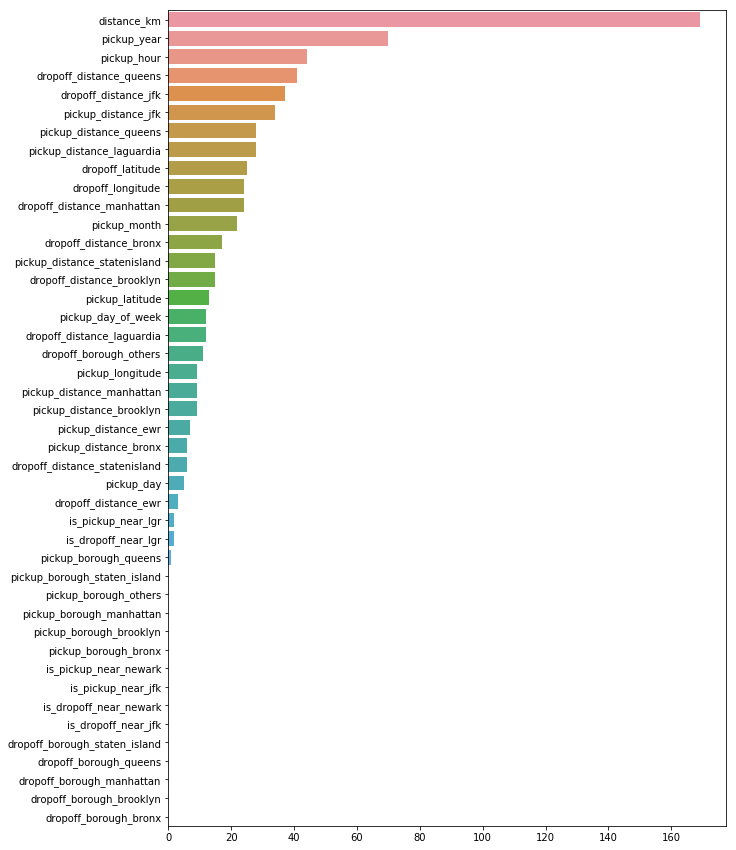

In [58]:
lgbm_feature_importance=sorted(zip(map(lambda x: round(x, 4),lgb_bst.feature_importance()), X_train.columns),reverse=True)
plt.figure(figsize=(10,15))
sns.barplot([imp for imp,feature in lgbm_feature_importance],[feature for imp,feature in lgbm_feature_importance])


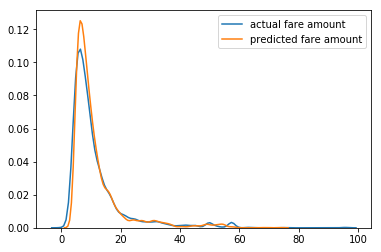

In [59]:
sns.kdeplot((Y_test),label='actual fare amount')
sns.kdeplot((lgb_pred),label='predicted fare amount')